In [3]:
# Define the feature map
num_features = len(normalized_fingerprints[0])
feature_map = ZZFeatureMap(feature_dimension=num_features, reps=2, entanglement='linear')
#feature_map.decompose().draw(output="mpl", style="clifford", fold=20)

In [ ]:


# Define the ansatz (variational form)
ansatz = TwoLocal(num_qubits=num_features, rotation_blocks='ry', entanglement_blocks='cz')

# Use the Aer simulator backend
backend = Aer.get_backend('aer_simulator_statevector')

# Define the optimizer
optimizer = SPSA(maxiter=100)

# Create the Variational Quantum Classifier
vqc = VQC(feature_map=feature_map,
          ansatz=ansatz,
          optimizer=optimizer)

# Train the VQC
vqc.fit(X_train, y_train)


[20:57:50] Explicit valence for atom # 0 N, 5, is greater than permitted
[20:57:50] Can't kekulize mol.  Unkekulized atoms: 9
[20:57:52] Can't kekulize mol.  Unkekulized atoms: 4
[20:57:52] Can't kekulize mol.  Unkekulized atoms: 4


Removed 4 invalid SMILES


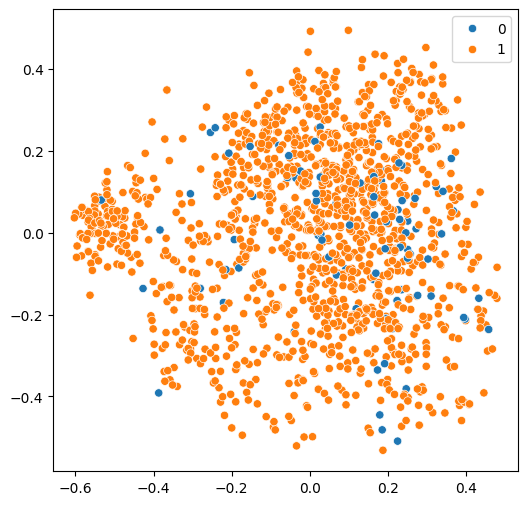

In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import MACCSkeys
import numpy as np
from qiskit_aer import Aer
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import QSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from qiskit.circuit.library import ZZFeatureMap
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Clintox dataset
clintox_data = pd.read_csv('clintox.csv')  # Adjust the path to your dataset

# Extract SMILES and labels
smiles_list = clintox_data['smiles']
labels = clintox_data['FDA_APPROVED']  # Adjust the column name to match your dataset

# Function to generate MACCS keys
def smiles_to_maccs(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        maccs = MACCSkeys.GenMACCSKeys(mol)
        return np.array(maccs)
    else:
        return None

maccs_keys = [smiles_to_maccs(smiles) for smiles in smiles_list]

# Remove None entries resulting from invalid SMILES
valid_data = [(maccs, label) for maccs, label in zip(maccs_keys, labels) if maccs is not None]
if len(valid_data) != len(smiles_list):
    print(f"Removed {len(smiles_list) - len(valid_data)} invalid SMILES")

# Separate fingerprints and labels again
maccs_keys, labels = zip(*valid_data)

# Normalize the MACCS keys
def normalize_vector(vector):
    norm = np.linalg.norm(vector)
    if norm == 0:
        return vector
    return vector / norm

normalized_maccs_keys = [normalize_vector(maccs) for maccs in maccs_keys]

# Apply PCA for dimensionality reduction
features = PCA(n_components=4).fit_transform(normalized_maccs_keys)

plt.rcParams["figure.figsize"] = (6, 6)
sns.scatterplot(x=features[:, 0], y=features[:, 1], hue=labels, palette="tab10")
plt.show()

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)



In [2]:
print(features.shape[1])

4


In [3]:
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel

num_features = features.shape[1]
adhoc_feature_map = ZZFeatureMap(feature_dimension=num_features, reps=2, entanglement="linear")

sampler = Sampler()

fidelity = ComputeUncompute(sampler=sampler)

adhoc_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=adhoc_feature_map)

In [5]:
from qiskit_machine_learning.algorithms import QSVC

qsvc = QSVC(quantum_kernel=adhoc_kernel)

qsvc.fit(X_train, y_train)

qsvc_score = qsvc.score(X_test, y_test)

print(f"QSVC classification test score: {qsvc_score}")

QSVC classification test score: 0.9459459459459459
